# **Perceptron model to classify linearly separable data**

In this problem statement, the objective is to classify a given **linearly separable dataset using a perceptron model**. The dataset consists of three distinct classes, each represented by two-dimensional feature vectors, with 500 data samples per class. **A one-against-one (OAO) classification strategy** will be employed to handle the multi-class nature of the dataset.

Furthermore, **the backpropagation algorithm will be implemented from scratch** for the aforementioned model to optimize its performance. This will involve computing gradients, updating model parameters iteratively, and ensuring effective learning within the perceptron framework.

### **What is a perceptron?**
![perceptron](perceptron.png)

The image represents a Perceptron, which is a fundamental building block of artificial neural networks

1. Inputs and weights
- The green circles labeled X₁ represent the inputs to the perceptron.
- Each input is associated with a weight (W₁, W₂, W₃, W₄) that determines its importance in the computation.

2. Summation and Bias
- Multiplication of each input by its corresponding weight.
- Adding all these products together.
- Including a bias term to adjust the threshold.

3. Activation Function
- The activation function (shown in the blue box) decides the final output.
- If the summation is greater than or equal to zero, the perceptron outputs 1.
- If the summation is less than zero, the perceptron outputs 0.

4. Output
- The final result is either 1 or 0, indicating a binary classification.

*Conclusion:* The perceptron is a binary classifier that determines whether an input belongs to one of two categories (in case when the data is linearly separable). If data is not linearly separable, a single-layer perceptron can't solve it (which led to the development of MLP and DL)


### **What is one-against-one approach?**
- A strategy for multi-class classification where you train a separate binary classifier for each pair of classes.
- For example, with 3 classes (A, B, C), you'll train classifiers for (A vs. B), (A vs. C), and (B vs. C).
- During prediction, each classifier "votes" for a class, and the class with the most votes is the predicted class.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

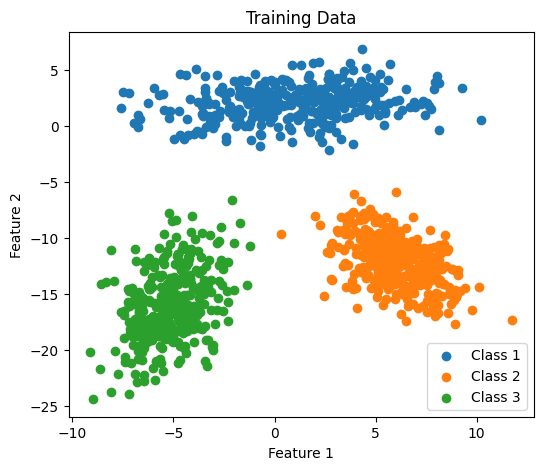

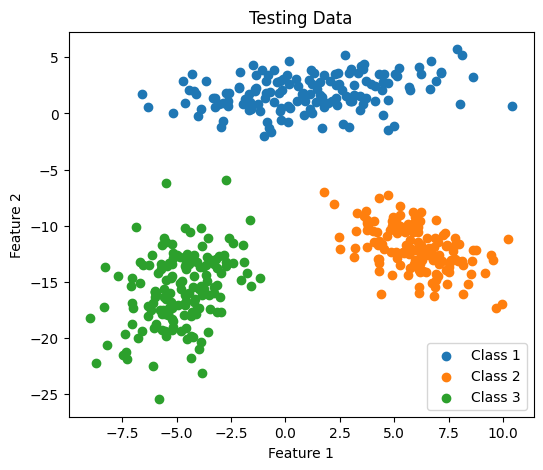

In [96]:
# Visualizing the dataset

def load_data(path):
    return np.loadtxt(path)

class1_data=load_data('CS671_Dataset_Assignment1/Dataset-1/LS/Class1.txt')
class2_data=load_data('CS671_Dataset_Assignment1/Dataset-1/LS/Class2.txt')
class3_data=load_data('CS671_Dataset_Assignment1/Dataset-1/LS/Class3.txt')

# combine all data and create lables
X=np.vstack((class1_data, class2_data, class3_data))
y=np.hstack((np.zeros(len(class1_data)), np.ones(len(class2_data)), 2*np.ones(len(class3_data))))


X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

def plot_data(X, y, title):
    plt.figure(figsize=(6,5))
    for i in range(3):
        plt.scatter(X[y==i, 0], X[y==i, 1], label=f'Class {i+1}')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_data(X_train, y_train, 'Training Data')
plot_data(X_test, y_test, 'Testing Data')

In [97]:
# creating a perceptron (perceptron algorithm)

class Perceptron(object):

    def __init__(self, input_dim, activation="step", lr=1, epochs=1000):
        self.lr=lr
        self.epochs=epochs
        self.activation_type=activation
        self.weights=np.random.randn(input_dim+1)
        self.errors=[]

    def activation(self, z):
        if self.activation_type=="step":
            return np.where(z>=0,1,0)
        elif self.activation_type=="sigmoid":
            return 1/(1+np.exp(-z))
        
    def train(self, X , y):
        X=np.hstack((np.ones((X.shape[0],1)), X))
        for epoch in range(self.epochs):
            total_error=0

            for i in range(X.shape[0]):
                xi=X[i]
                yi=y[i]
                output=self.activation(np.dot(xi, self.weights))

                error=yi-output
                self.weights+=self.lr*error*xi # backpropogation for single layer perceptron
                total_error+=error**2

            avg_error = total_error / X.shape[0]
            self.errors.append(avg_error)

    def predict(self, X):
        X=np.hstack((np.ones((X.shape[0], 1)), X))
        outputs=self.activation(np.dot(X, self.weights))
        return outputs
    
    def plot_error(self):
        plt.figure(figsize=(7,5))
        plt.plot(range(len(self.errors)), self.errors, label="Average Error", color="red")
        plt.xlabel("Epochs")
        plt.ylabel("Average Error")
        plt.title("Average Error vs. Epochs on Train Data")
        plt.legend()
        plt.show()


In [98]:
# one-against-one approach

def train_oao_classifier(X_train, y_train, class1, class2, activation="step"):
    indices = np.where((y_train == class1) | (y_train == class2))
    X_binary = X_train[indices]
    y_binary = y_train[indices]
    y_binary = np.where(y_binary == class1, 0, 1) 

    perceptron = Perceptron(input_dim=X_train.shape[1], activation=activation)
    perceptron.train(X_binary, y_binary)
    perceptron.plot_error()
    
    return perceptron

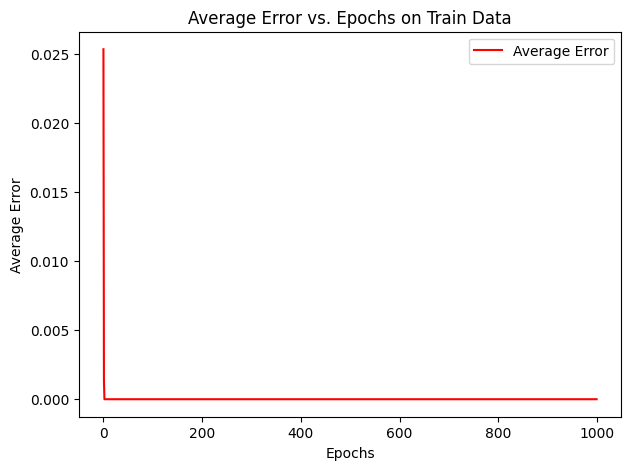

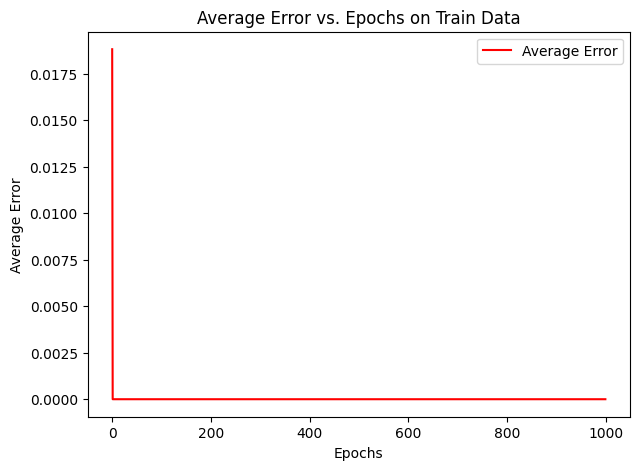

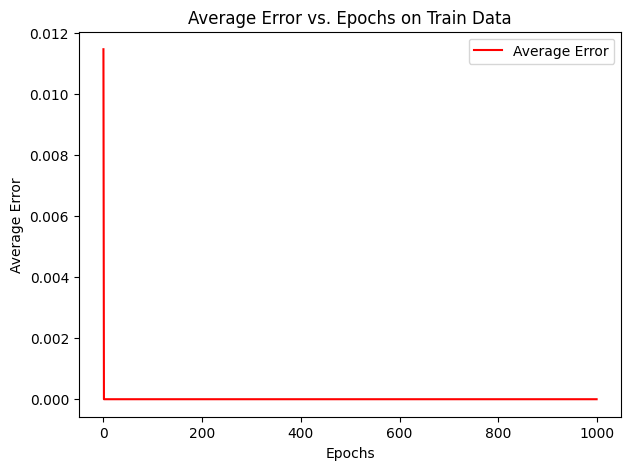

In [99]:
# train classifiers for each pair

class_pairs = [(0, 1), (0, 2), (1, 2)]
classifiers = {}

for pair in class_pairs:
    classifiers[pair] = train_oao_classifier(X_train, y_train, pair[0], pair[1], activation="step")

In [100]:
# predicting from majority votes from OAO classifiers

def predict_oa(X, classifiers):
    votes = np.zeros((X.shape[0], 3))

    for (class1, class2), clf in classifiers.items():
        preds = clf.predict(X)
        for i, pred in enumerate(preds):
            if pred == 0:
                votes[i, class1] += 1
            else:
                votes[i, class2] += 1

    return np.argmax(votes, axis=1)

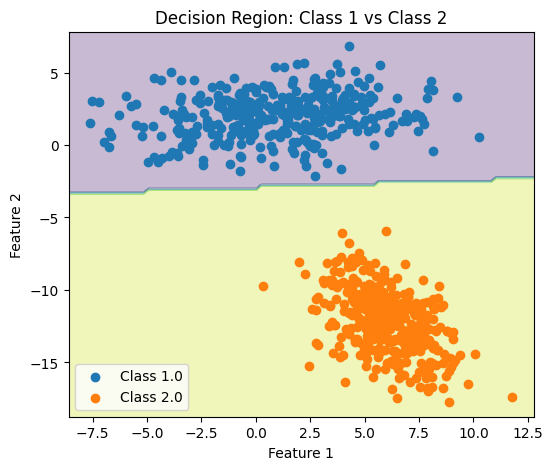

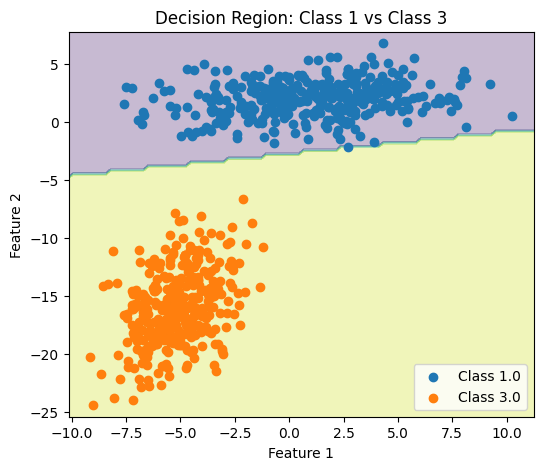

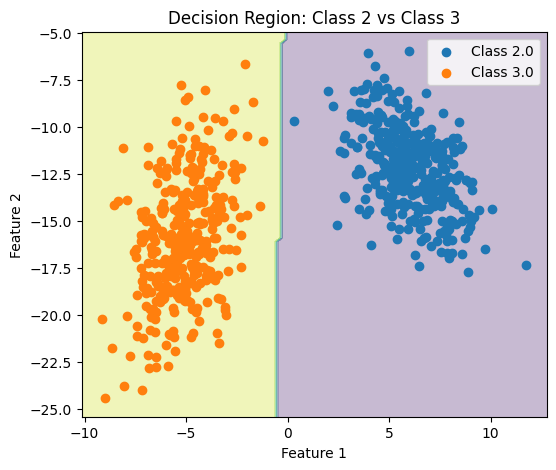

In [101]:
#plot decision boundaries for each pair of classes

def plot_decision_region(X, y, perceptron, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = perceptron.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    
    for i in np.unique(y):
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i+1}')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

for pair in class_pairs:
    perceptron = classifiers[pair]  # Get trained perceptron
    indices = np.where((y_train == pair[0]) | (y_train == pair[1]))  
    plot_decision_region(X_train[indices], y_train[indices], perceptron, 
                         title=f"Decision Region: Class {pair[0]+1} vs Class {pair[1]+1}")


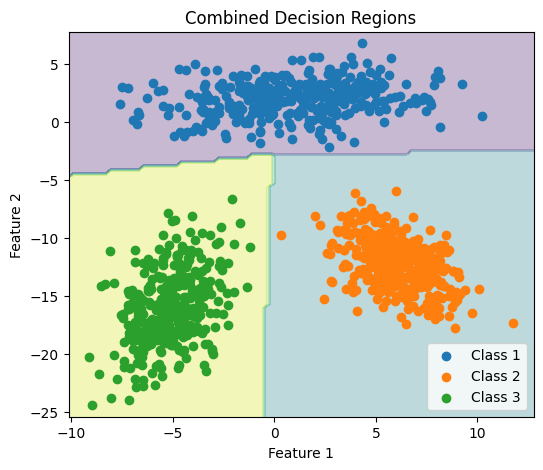

In [102]:
#combined decision boundary

def plot_combined_decision_region(X, y, classifiers, title="Combined Decision Regions"):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))

    # Predict using OAO majority voting
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_oa(grid_points, classifiers)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.3)

    for i in range(3):
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i+1}')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

plot_combined_decision_region(X_train, y_train, classifiers)

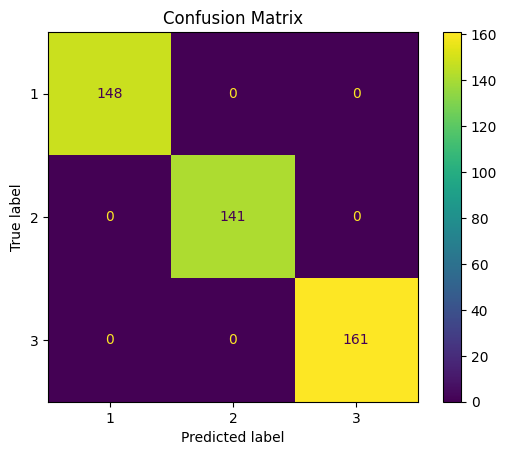

Model Accuracy: 100.00%


In [103]:
y_pred = predict_oa(X_test, classifiers)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print("Confusion Matrix:\n", conf_matrix)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[1,2,3])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

print(f"Model Accuracy: {accuracy:.2%}")